In [6]:
import numpy as np

class PCA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # mean centering
        self.mean = np.mean(X, axis=0)
        X = X -  self.mean

        # covariance, functions needs samples as columns
        cov = np.cov(X.T)

        # eigenvectors, eigenvalues
        eigenvectors, eigenvalues = np.linalg.eig(cov)

        # eigenvectors v = [:, i] column vector, transpose this for easier calculations
        eigenvectors = eigenvectors.T

        # sort eigenvectors
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.components = eigenvectors[:self.n_components]

    def transform(self, X):
        # projects data
        X = X - self.mean
        return np.dot(X, self.components.T)

In [181]:
import pickle

# Load the list from the file using pickle
with open("dataset.pkl", "rb") as f:
    my_list = pickle.load(f)



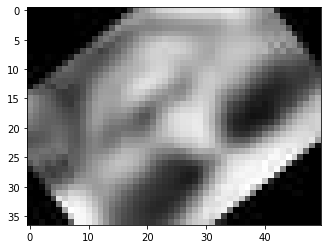

In [182]:
import matplotlib.pyplot as plt
import cv2

# Get a random image from the dataset
sample_image = my_list[0][20]
sample_image = sample_image.reshape(37,50)
# Display the image

plt.imshow(sample_image, cmap='gray')
plt.show()

In [183]:
X , y , names = my_list

In [165]:
import numpy as np

In [166]:
X = np.array(X)

In [167]:
print(X.shape)

(299, 1850)


In [168]:
import numpy as np
from sklearn import  metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import svm

In [169]:
# Apply PCA to the raw pixel values
n_components = 200
pca = PCA(n_components=n_components)
eigenfaces = pca.fit(X)
eigenfaces = pca.transform(X)

In [170]:
eigenfaces.shape

(299, 200)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(eigenfaces, y, test_size=0.1,random_state=50)


In [172]:
# Train an SVM model using the training set
clf = svm.SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)


SVC(C=1, kernel='linear')

In [173]:
y_pred = clf.predict(X_test)


In [186]:
# Evaluate the performance of the model
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
f1_score = metrics.f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1_score}")

Accuracy: 0.4666666666666667
Precision: 0.5948148148148147
Recall: 0.4666666666666667
F1 score: 0.515751633986928


C:\Users\A\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [185]:
import cv2

def predict_image(path,model,pca,names):
    # Load the pre-trained face detection classifier
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Set the new width and height
    new_width = 500
    new_height = 500

    img = cv2.imread(path)

    # Resize the image
    resized_img = cv2.resize(img, (new_width, new_height))
    gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    print(faces)
    for (x, y, w, h) in faces:
        cropped_img = gray[y:y+h, x:x+w]

    cropped_img = cv2.resize(cropped_img,(50,37))
    flatten_img = cropped_img.flatten().reshape(1,-1)
    flatten_img = pca.transform(flatten_img)
    result = model.predict(flatten_img)
    confidence = model.decision_function(flatten_img)

    # Print the prediction and confidence
    print("Prediction:", names[int(result)])
    print("Confidence:", confidence)

In [178]:
predict_image("images/test/mina/test.jpg",clf,pca,names)

[[ 14   1  67  67]
 [171  61 149 149]
 [194 145 116 116]
 [ 48 181  28  28]]
Prediction: abram
Confidence: [[0.8353388  3.13803198 2.04037688 0.87066431 3.14454403]]


In [188]:
with open('trained_model.pkl', 'wb') as f:
    pickle.dump((pca, clf,names), f)

In [189]:
import pickle

# Load the saved model from the file
with open('trained_model.pkl', 'rb') as f:
    pca, clf ,names= pickle.load(f)


SVC(C=1, kernel='linear')
